In [10]:
from tqdm import tqdm
from pathlib import Path
import json
import plotly.graph_objs as go
from PIL import Image
from datetime import datetime

from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
from ahrs.utils import WMM
from scipy.spatial.transform import Rotation as R
from scipy import integrate
import sys
import os
import numpy as np
import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from dataclasses import dataclass

import matplotlib.pyplot as plt # visualization
# plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')
sys.path.append(os.path.join(os.getcwd(), "..", ".."))

from support.imu_calculations import *

from mpl_toolkits.mplot3d import Axes3D
def plot_3d_graph(x,y,z, c=None):
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.scatter(x, y, z, c=c)
    ax.set_title("acce")
    plt.show()


In [2]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\omni_9dof_feb_28_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
# _sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

In [12]:
_imu_df = _sk_df[['time', "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]]

_vel_df = calculate_imu_velocity(_imu_df, filter_size=51, filter_order=1, zero_drift=300)
_vel_df.head()

,time,ax,ay,az,gx,gy,gz,mx,my,mz,vel_x,vel_y,vel_z
0,1.677583e+09,0.097656,0.067383,-1.143066,0.061035,0.061035,0.854492,131.261017,-318.713989,80.931892,0.000000,0.000000,0.000000
1,1.677583e+09,0.097168,0.067383,-1.141113,0.061035,0.000000,0.854492,134.857208,-332.958191,94.707535,0.000002,-0.000005,-0.000046
2,1.677583e+09,0.098633,0.067871,-1.139160,0.061035,-0.061035,0.854492,133.059113,-327.616608,86.097755,0.000018,-0.000005,-0.000073
3,1.677583e+09,0.099609,0.067871,-1.140625,0.061035,0.000000,0.793457,136.655304,-327.616608,92.985580,0.000044,-0.000005,-0.000115
4,1.677583e+09,0.095703,0.067871,-1.141113,0.122070,-0.061035,0.915527,145.645782,-315.152924,87.819710,0.000031,-0.000006,-0.000161


In [17]:
time_ = _imu_df.time

vel_x = integrate.cumtrapz(_imu_df.ax,_imu_df.time, _imu_df.time.diff(), initial=0)
vel_y = integrate.cumtrapz(_imu_df.ay,_imu_df.time, _imu_df.time.diff(), initial=0)
vel_z = integrate.cumtrapz(_imu_df.az,_imu_df.time, _imu_df.time.diff(), initial=0)

pos_x = integrate.cumtrapz(vel_x, _imu_df.time, _imu_df.time.diff(), initial=0)
pos_y = integrate.cumtrapz(vel_y, _imu_df.time, _imu_df.time.diff(), initial=0)
pos_z = integrate.cumtrapz(vel_z, _imu_df.time, _imu_df.time.diff(), initial=0)

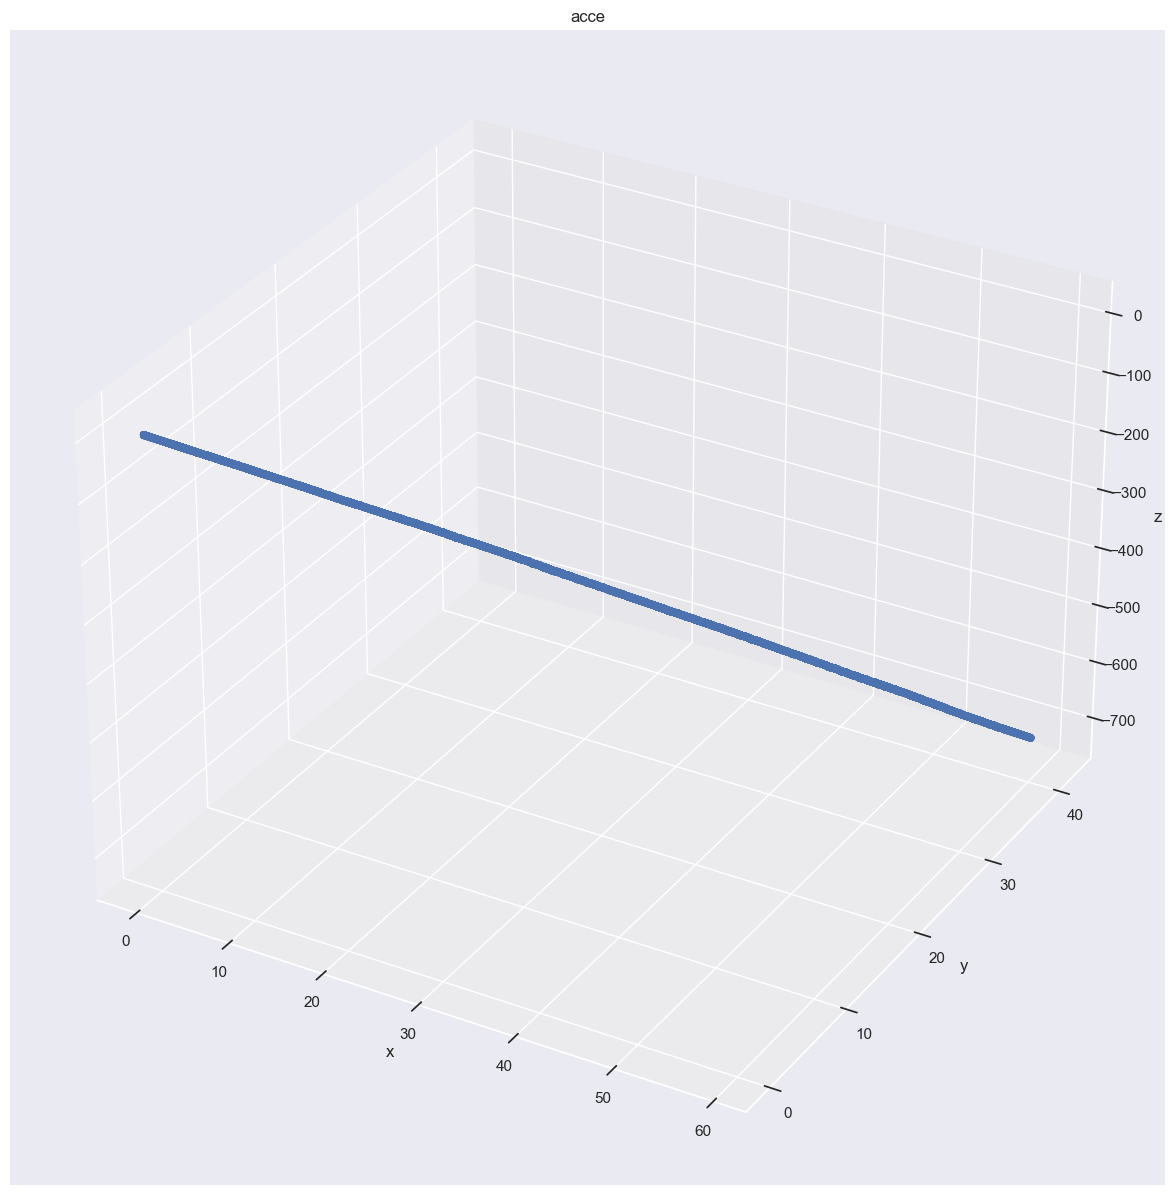

In [18]:
plot_3d_graph(vel_x, vel_y, vel_z)

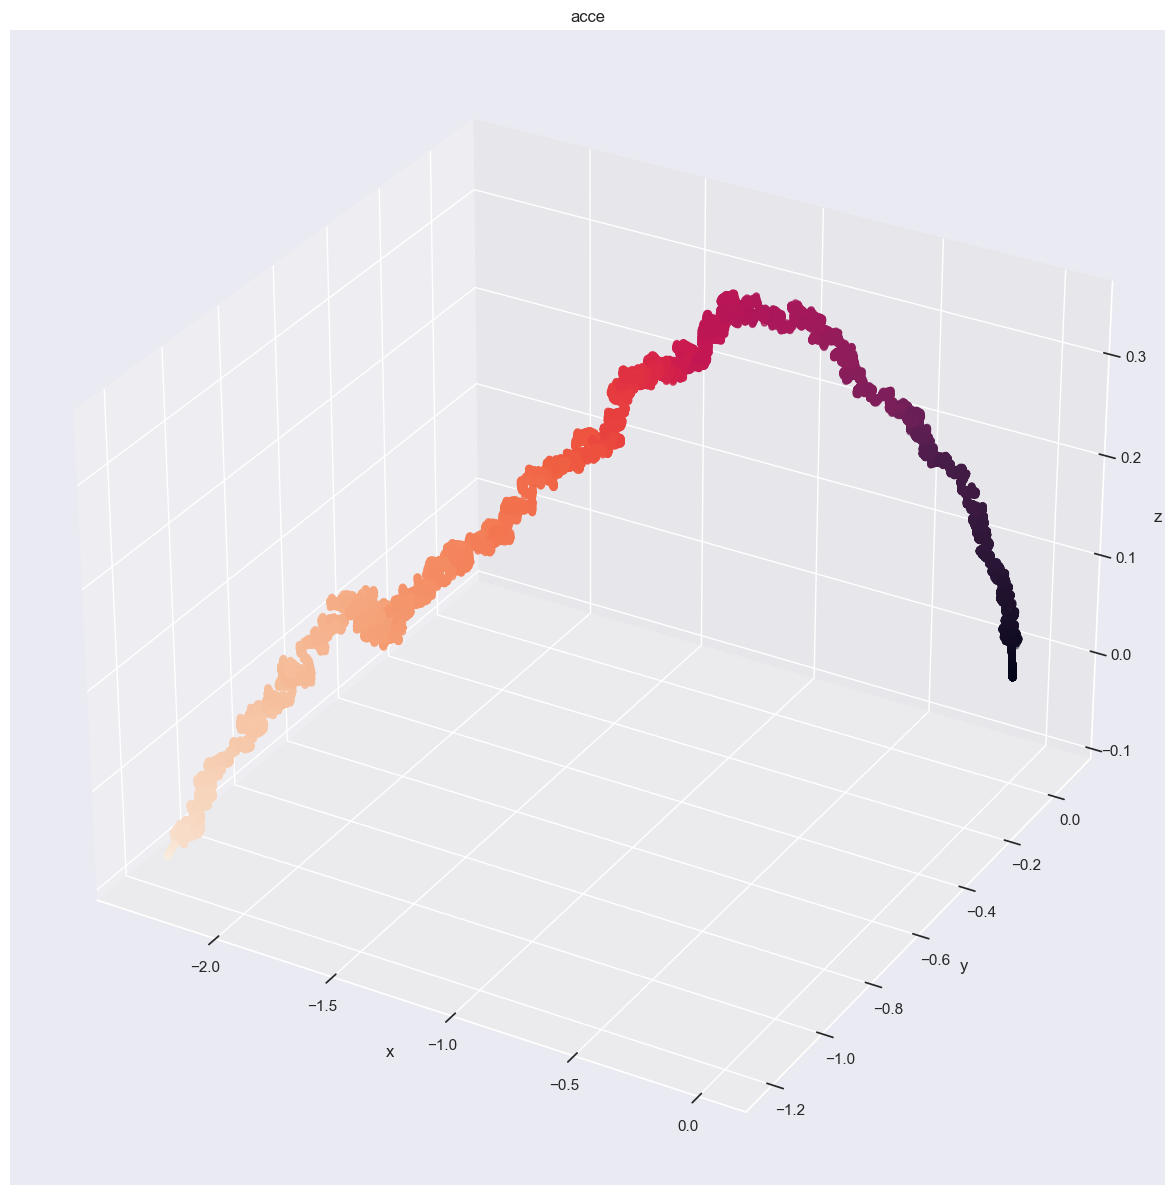

In [14]:
plot_3d_graph(_vel_df.vel_x, _vel_df.vel_y, _vel_df.vel_z, c=time_)

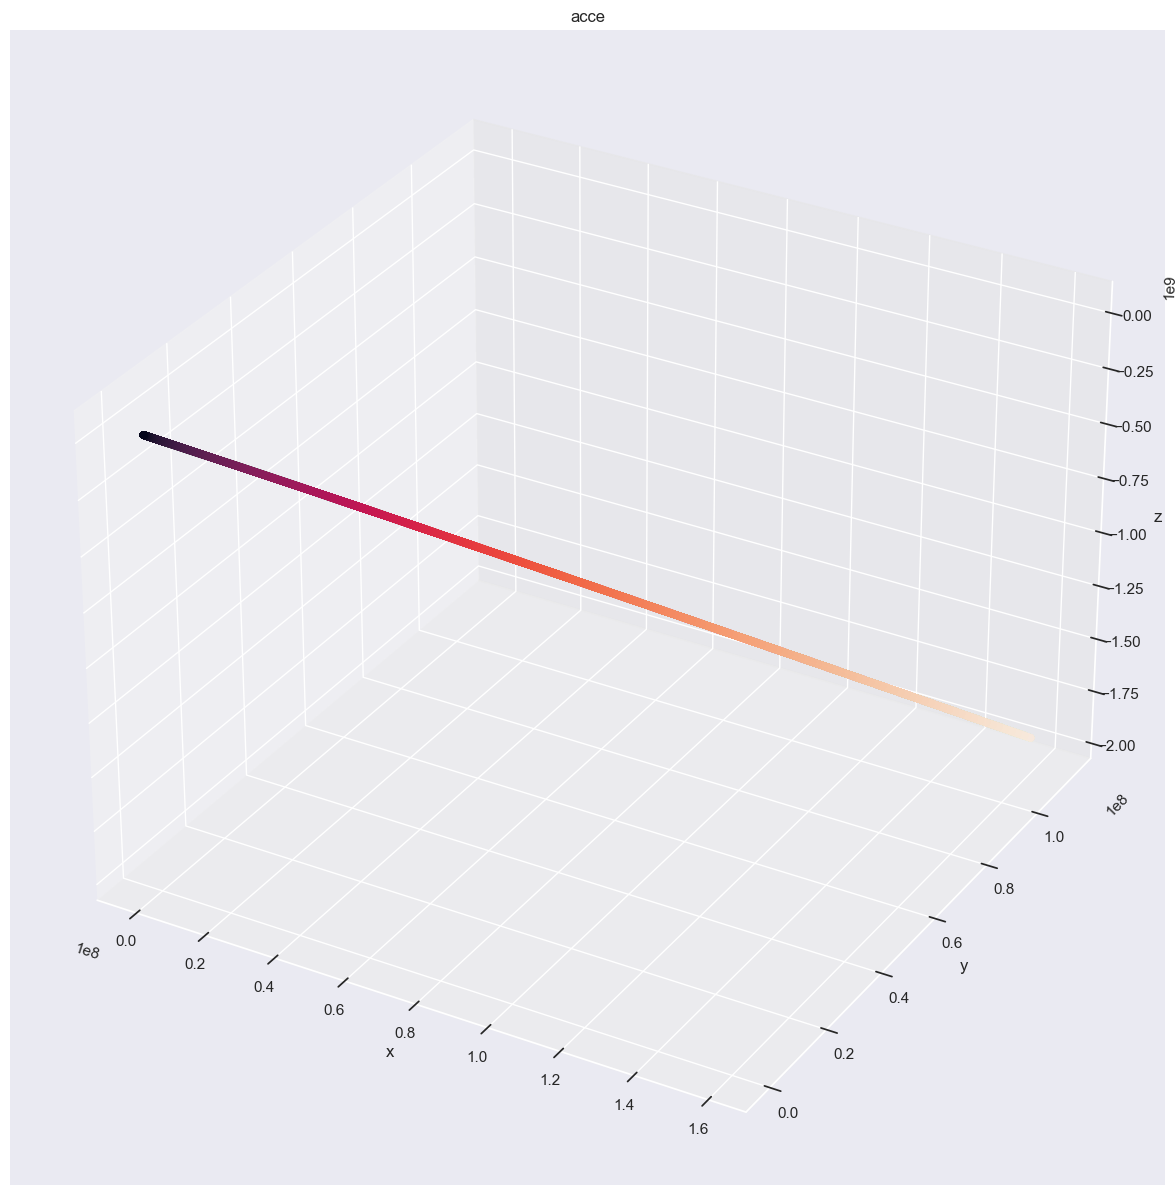

In [7]:
plot_3d_graph(
    pos_x,
    pos_y,
    pos_z,
    _imu_df.time
)

In [26]:
gyro = _imu_df[["gx", "gy", "gz"]].values
acce = _imu_df[["ax", "ay", "az"]].values
magn = _imu_df[["mx", "my", "mz"]].values


ekf_estimator = EKF(gyr=gyro, acc=acce, mag=magn, frequency=50.0)
# Initializing the class with the sensor data generates our Quaternion in the Q Variable

Q = ekf_estimator.Q
n_samples = acce.shape[0]
new_acce = np.zeros((n_samples, 3))
# Initializing Array to hold the Linear acceleration Vector

for t in range(n_samples):
    r = R.from_quat(Q[t])
    # Getting a Rotation Matrix from the Quaternions
    new_acce[t] = np.matmul(r.as_matrix().T,acce[t])
    # matmul Rotation Matrix Transpose to orignal Acceleration to produce the clean linear acceleration

In [29]:
new_accel_df = pd.DataFrame(new_acce, columns=["ax", "ay", "az"])

vel_x = integrate.cumtrapz(new_accel_df.ax,_imu_df.time, initial=0)
vel_y = integrate.cumtrapz(new_accel_df.ay,_imu_df.time, initial=0)
vel_z = integrate.cumtrapz(new_accel_df.az,_imu_df.time,initial=0)

pos_x = integrate.cumtrapz(vel_x, _imu_df.time, initial=0)
pos_y = integrate.cumtrapz(vel_y, _imu_df.time, initial=0)
pos_z = integrate.cumtrapz(vel_z, _imu_df.time, initial=0)


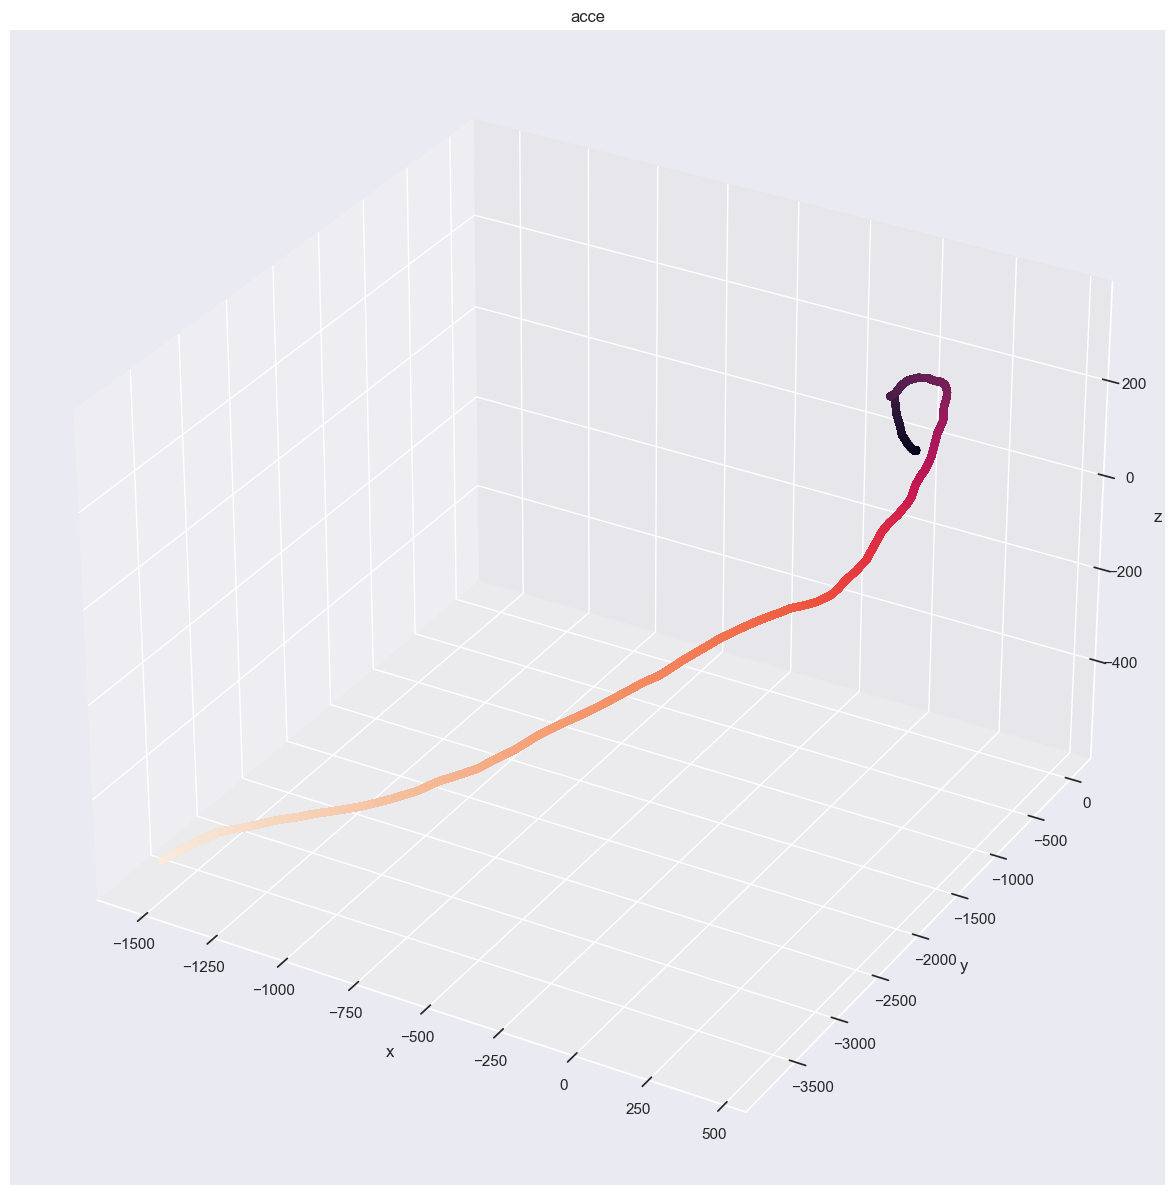

In [31]:
plot_3d_graph(
    pos_y,
    pos_x,
    pos_z,
    _imu_df.time   
)

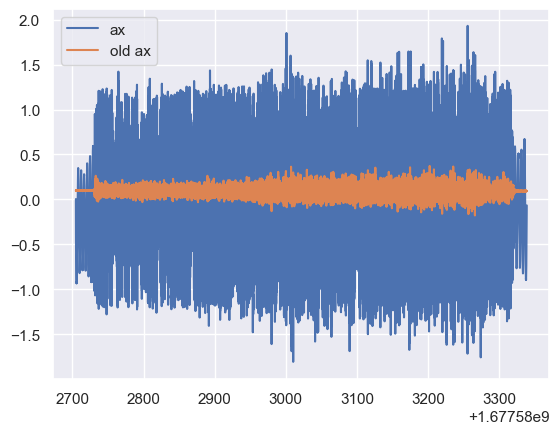

In [38]:
plt.plot(_imu_df.time, new_accel_df.ax, label="ax")
plt.plot(_imu_df.time, _imu_df.ax, label="old ax")
plt.legend()
# plt.plot(_imu_df.time, new_accel_df.ay)
# plt.plot(_imu_df.time, new_accel_df.az)

